In [8]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import seaborn as sns
import os

In [2]:
folders = glob.glob('results/*')
folders

['results/2025-03-03', 'results/2025-02-28']

In [3]:
levels = glob.glob(f'{folders[-1]}/*')
levels

['results/2025-02-28/lic3',
 'results/2025-02-28/lic0',
 'results/2025-02-28/lic2',
 'results/2025-02-28/lic1']

In [4]:
def read_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/*'):
        num_cores = int(Path(file).stem) + 1
        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['metric']
            value = row['average']
            if (metric == 'perf-freq'):
                value *= num_cores
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'core_count': num_cores}])])

    return df

In [5]:
freq_vs_number_of_cores = pd.DataFrame()

for level in levels:
    lic_data = read_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    freq_vs_number_of_cores = pd.concat([freq_vs_number_of_cores, lic_data])

In [6]:
license_level_to_name = {
    'lic0': 'SSE',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

LIC_NAME = 'License name'
CORE_COUNT = 'Number of active cores'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [MHz]'
POWER_WATT = 'Power draw of package 0 [W]'

freq_vs_number_of_cores[LIC_NAME] = freq_vs_number_of_cores['level'].apply(lambda v: license_level_to_name[v])
freq_vs_number_of_cores[CORE_COUNT] = freq_vs_number_of_cores['core_count']

freq_vs_number_of_cores[MAX_TURBO_FREQ] = freq_vs_number_of_cores['value'] * 1000
freq_vs_number_of_cores[POWER_WATT] = freq_vs_number_of_cores['value']

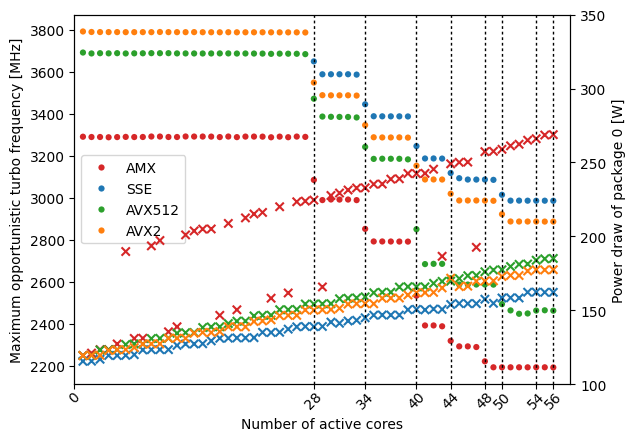

In [7]:
# plt.figure(figsize=(10,6))
colors = [sns.color_palette()[3], sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[1]]

ax = sns.scatterplot(data=freq_vs_number_of_cores[freq_vs_number_of_cores['metric'] == 'perf-freq'], x=CORE_COUNT, y=MAX_TURBO_FREQ, hue=LIC_NAME, linewidth=1.5, marker='o', palette=colors)
# ax.get_legend().remove()
plt.xticks(rotation=45)

ax.legend(loc='center left')

ax2 = ax.twinx()

# handles, labels = ax.get_legend_handles_labels()
# order = [1,3,2,0]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

sns.scatterplot(ax=ax2, data=freq_vs_number_of_cores[freq_vs_number_of_cores['metric'] == 'sysfs-powercap-rapl/package-0'], x=CORE_COUNT, y=POWER_WATT, hue=LIC_NAME, linewidth=1.5, marker='x', palette=colors)
ax2.set_ylim(100, 350)
ax2.get_legend().remove()

# handles, labels = ax2.get_legend_handles_labels()
# order = [1,3,2,0]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
# ax2.set_ylim(0, 10)

# Overlay the blue markers for the SSE2 license on the left
# sse_marker = freq_vs_number_of_cores[freq_vs_number_of_cores[LIC_NAME] == 'SSE']
# plt.plot(sse_marker[CORE_COUNT], sse_marker[MAX_TURBO_FREQ], color=sns.color_palette()[0], linestyle='None', markeredgewidth=0.0, ms=4.5, marker=matplotlib.markers.MarkerStyle("o", fillstyle="left"))

buckets = [28,34,40,44,48,50,54,56]

for i in buckets:
    plt.axvline(x=i, color='black', dashes=[2], linewidth=1)

# ax.set_ylim(0, 4000)
ax.set_xlim(0, 58)
ax.set_xticks([0] + buckets)

# plt.xticks(rotation=45)
ax.tick_params(axis='x', pad=0)

plt.savefig('../../thesis/fig/validate-avx-frequency-license-bands.pdf', bbox_inches='tight')